In [2]:
import os

import polars as pl
import pyref.fitting as fit
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd


import scienceplots

CPU_COUNT = os.cpu_count()
plt.style.use(["science"])
# Set RCParams
plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 300
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

# Load the Data Files


Dataset loaded from ../fitting/reflectivity_data.parquet


(<Axes: ylabel='$R$'>, <Axes: xlabel='$q (\\AA^{-1})$'>)

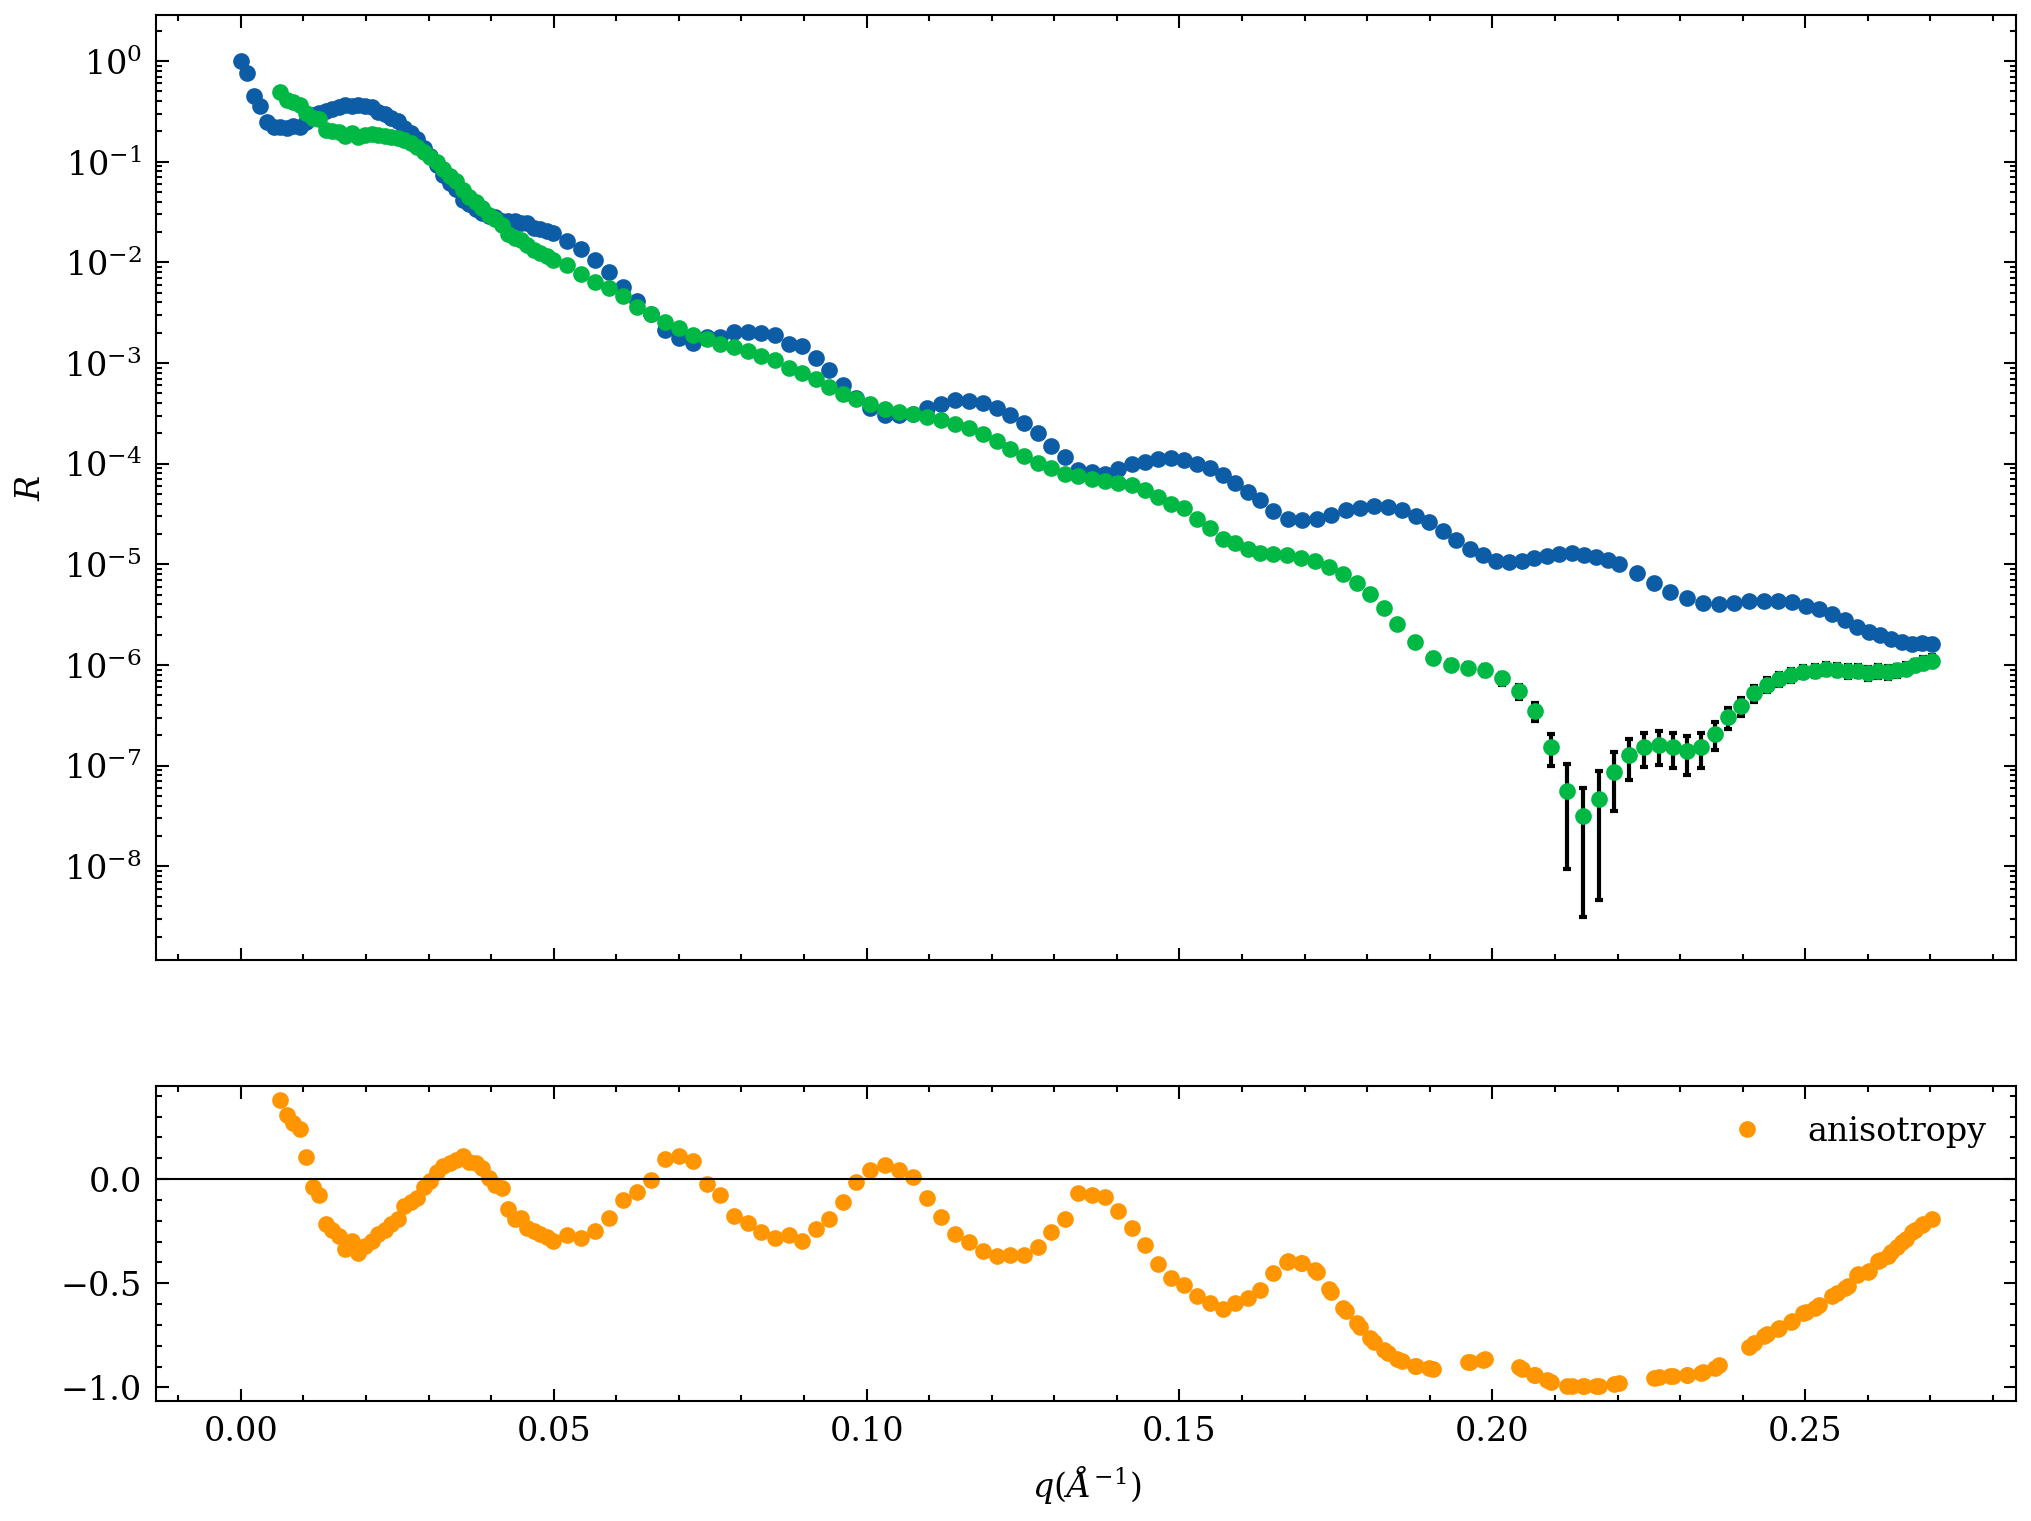

In [3]:
def load_reflectivity_dataset(filename):
    """
    Load reflectivity dataset from a parquet file.

    Parameters
    ----------
    filename : str
        Input filename (should be a .parquet file)

    Returns
    -------
    dict
        Dictionary containing XrayReflectDataset objects with energy keys
    """
    # Load the DataFrame
    df_load = pl.read_parquet(filename)

    # Reconstruct the data dictionary
    data_reconstructed = {}

    # Group by energy
    for group_key, group_data in df_load.group_by("energy"):
        energy_val = group_key[0]  # Extract energy value from the group key tuple

        # Extract arrays
        Q = group_data["Q"].to_numpy()
        R = group_data["R"].to_numpy()
        dR = group_data["dR"].to_numpy()

        # Create XrayReflectDataset
        dataset = fit.XrayReflectDataset(data=(Q, R, dR))
        data_reconstructed[str(energy_val)] = dataset

    print(f"Dataset loaded from {filename}")
    return data_reconstructed


# # Save the dataset to a parquet file
# save_reflectivity_dataset(data, "reflectivity_data.parquet")
# # Load the dataset back from the parquet file
loaded_data = load_reflectivity_dataset("../fitting/reflectivity_data.parquet")
loaded_data["283.7"].plot(label="283.7 eV data")

In [4]:
from pandas.core.frame import DataFrame
from typing import Any


from numpy._typing._array_like import NDArray
from numpy._typing import _64Bit
from numpy import complexfloating
import numpy as np

from numba import njit  # type: ignore

from scipy.interpolate import interp1d
from pyref.fitting.structure import PXR_Component as Component
from pyref.fitting.structure import Parameter, possibly_create_parameter
import pandas as pd

@njit(cache=True, fastmath=True)
def _orientation_profile_core(
    total_thick,
    depth,
    characteristic_thickness,
    max_angle,
    initial_angle,
):
    thick = depth # total_thick - depth
    return max_angle * (1 - np.exp(-thick / characteristic_thickness)) + initial_angle


def orientation_profile(total_thick, depth, characteristic_thickness, max_angle, initial_angle):
    if np.isscalar(depth):
        return _orientation_profile_core(
            total_thick,
            depth,
            characteristic_thickness,
            max_angle,
            initial_angle,
        )

    depth_arr = np.asarray(depth, dtype=np.float64)
    return _orientation_profile_core(
        total_thick,
        depth_arr,
        characteristic_thickness,
        max_angle,
        initial_angle,
    )

class OrientationProfile(Component):
    def __init__(
        self,
        ooc: pd.DataFrame,
        total_thick,
        surface_roughness,
        density,
        characteristic_thickness,
        max_angle,
        initial_angle,
        energy,
        energy_offset: float = 0,
        name: str | None = None,
        microslab_max_thickness: float = 1,
        ):
        super(OrientationProfile, self).__init__(name = name)
        # Load the OOC data
        mask = (ooc["energy"] > energy - 1) & (ooc["energy"] < energy + 1)
        ooc = ooc[mask]
        self.n_xx = interp1d(ooc["energy"], ooc["n_xx"], bounds_error=False)
        self.n_ixx = interp1d(ooc["energy"], ooc["n_ixx"], bounds_error=False)
        self.n_zz = interp1d(ooc["energy"], ooc["n_zz"], bounds_error=False)
        self.n_izz = interp1d(ooc["energy"], ooc["n_izz"], bounds_error=False)
        self.energy = energy
        # Setup the parameters
        self.total_thick = possibly_create_parameter(total_thick, name="total_thick")
        self.surface_roughness = possibly_create_parameter(surface_roughness, name="surface_roughness")
        self.density = possibly_create_parameter(density, name="density")
        self.characteristic_thickness = possibly_create_parameter(characteristic_thickness, name="characteristic_thickness")
        self.max_angle = possibly_create_parameter(max_angle, name="max_angle")
        self.initial_angle = possibly_create_parameter(initial_angle, name="initial_angle")
        self.energy_offset = possibly_create_parameter(energy_offset, name="energy_offset")
        # Initialize the microslabs
        self.microslab_max_thickness = microslab_max_thickness
        # Load into the super class
        self._parameters = super().parameters
        self._parameters.extend([
            self.total_thick,
            self.surface_roughness,
            self.density,
            self.characteristic_thickness,
            self.max_angle,
            self.initial_angle,
            self.energy_offset,
        ])

    def varying_parameters(self):
        return [p for p in self._parameters if p.vary]

    @property
    def num_slabs(self) -> int:
        return int(np.ceil(float(self.total_thick.value) / self.microslab_max_thickness))

    @property
    def slab_thick(self) -> float:
        return self.total_thick.value / self.num_slabs

    @property
    def dist(self) -> NDArray[np.float64]:
        return np.linspace(self.slab_thick, self.total_thick.value, self.num_slabs)

    @property
    def mid_points(self) -> NDArray[np.float64]:
        return np.linspace(
            self.slab_thick / 2,
            self.total_thick.value - self.slab_thick / 2,
            self.num_slabs,
        )

    @property
    def parameters(self) -> Any:
        return self._parameters

    def orientation(
        self,
        depth: NDArray[np.float64] | float,
    ) -> NDArray[np.float64] | float:
        t = self.total_thick.value - depth
        return orientation_profile(
            self.total_thick.value, t, self.characteristic_thickness.value,
            self.max_angle.value, self.initial_angle.value
            )

    def get_energy(self) -> float:
        return float(self.energy) + float(self.energy_offset.value)

    @property
    def n(self)  -> NDArray[complexfloating[_64Bit, _64Bit]]:
        """
        Optical constants of the material.

        Returns
        -------
        n : np.ndarray
            Optical constants of the material.
        """
        e = self.get_energy()
        return np.array(
            [
                [self.n_xx(e) + self.n_ixx(e) * 1j, 0],
                [0, self.n_zz(e) + self.n_izz(e) * 1j],
            ],
            dtype=np.complex128,
        )

    def tensor(
        self,
        energy: float | None = None,
    ) -> NDArray[complexfloating[_64Bit, _64Bit]]:
        if energy is None:
            energy = self.get_energy()
        depth_arr = self.mid_points
        ori = self.orientation(depth_arr)
        n = self.n

        c = np.square(np.cos(ori))
        s = np.square(np.sin(ori))
        xx = (n[0, 0] * (1 + c) + n[1, 1] * s) / 2
        zz = n[0, 0] * s + n[1, 1] * c

        tensor = np.zeros((depth_arr.size, 3, 3), dtype=np.complex128)
        tensor[:, 0, 0] = xx
        tensor[:, 1, 1] = xx
        tensor[:, 2, 2] = zz
        return tensor

    @property
    def iso(self) -> NDArray[np.float64]:
        return np.trace(self.tensor(), axis1=1, axis2=2)

    @property
    def delta(self) -> NDArray[np.float64]:
        return np.real(self.iso)

    @property
    def beta(self) -> NDArray[np.float64]:
        return np.imag(self.iso)

    def slabs(self, structure=None) -> NDArray[np.float64]:
        slabs = np.zeros((self.num_slabs, 4))
        slabs[..., 0] = self.slab_thick
        slabs[..., 1] = self.delta
        slabs[..., 2] = self.beta
        slabs[0, 3] = self.surface_roughness.value
        return slabs

In [9]:
import pickle

with open("../fitting/fitting_results_fixed_3.pkl", "rb") as f:
    dft_constrained = pickle.load(f)
with open("../fitting/fitting_results_free_model_2.pkl", "rb") as f:
    exp_constrained = pickle.load(f)

In [10]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from helper import reduced_chi2




def rxr(x, model, pol):
    _pol = model.pol
    model.pol = pol
    y = model(x)
    model.pol = _pol
    return y


def anisotropy(x, model):
    r_s = rxr(x, model, "s")
    r_p = rxr(x, model, "p")
    return (r_p - r_s) / (r_p + r_s)


def plot_vertically_offset_energies(ax, energies, exp_objectives, dft_objectives, loaded_data, title, offset_scale=-1.5, exp_corrections=True):
    """
    Helper function to plot multiple energies with vertical offsets.
    """
    import matplotlib.cm as cm

    # Create color map
    cmap = plt.colormaps.get_cmap('tab20')
    xdata = np.linspace(0.0005, 0.27, 1000)
    for idx, E in enumerate(energies):
        if E not in exp_objectives:
            continue

        o_exp = exp_objectives[E]
        o_dft = dft_objectives[E]
        data = loaded_data[str(E)]

        # Vertical offset (powers of 10)
        offset = 10 ** (offset_scale * idx)
        color = cmap(idx)

        # Plot data points (smaller markers)
        for pol, marker_style in [("s", "o"), ("p", "s")]:
            pol_data = getattr(data, pol)
            ax.errorbar(
                pol_data.x,
                pol_data.y * offset,
                yerr=pol_data.y_err * offset,
                lw=0,
                color=color,
                capsize=.5,
                # ecolor="k",
                marker="o",
                elinewidth=.5,
                markersize=.5,
                markerfacecolor=color,
                markevery=2,
                errorevery=2,
            )

        # Plot fits
        for pol in ["s", "p"]:
            pol_data = getattr(data, pol)
            # if not exp_corrections:
            #     for o in [o_exp, o_dft]:
            #         o.model.bkg.value = 0.0
            #         o.model.theta_offset_s.value = 0.0
            #         o.model.theta_offset_p.value = 0.0
            #         o.model.scale_s.value = 1.0
            #         o.model.scale_p.value = 1.0

            # Free fit (exp_constrained) - solid line
            y_exp = rxr(xdata, o_exp.model, pol)
            ax.plot(xdata, y_exp * offset, color="k", lw=.5, ls="-", zorder=-10)

            # DFT constrained fit - dashed line
            y_dft = rxr(xdata, o_dft.model, pol)
            ax.plot(xdata, y_dft * offset, color="k", lw=.5, ls="--", zorder=-10)

    # Configure axes
    ax.set_yscale("log")
    ax.set_ylabel(r"Reflectivity (Vertically Offset)")
    ax.set_xlim(0.002, 0.07)
    ax.minorticks_on()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(offset * pol_data.y.min(), 1)
    ax.set_xticks([ 0.03, 0.06])
    ax.set_xticklabels([r"$3$", r"$6$"])
    # No legend in bottom panels - will be consolidated in top panel


def plot_all_results(
    exp_constrained,
    dft_constrained,
    loaded_data,
    save_path: Path | str | None = None
):
    """
    Plot all results in a single figure matching the target layout:
    - Top: 250 eV and 283.7 eV spanning two columns
    - Bottom left: non-resonant energies (between 250 and 283.7 eV)
    - Bottom right: resonant energies (greater than 283.7 eV)
    """
    import matplotlib.gridspec as gs

    # Create figure and gridspec (single column)
    fig = plt.figure(figsize=(2.5, 3.5))
    grid = gs.GridSpec(2, 2, figure=fig, height_ratios=[1, 1.2], hspace=0.05, wspace=0.01)

    # Top panel spans both columns
    ax_top = fig.add_subplot(grid[0, :])

    # Bottom panels
    ax_bottom_left = fig.add_subplot(grid[1, 0])
    ax_bottom_right = fig.add_subplot(grid[1, 1])

    # ===== TOP PANEL: 250 eV and 283.7 eV =====
    comparison_energies = np.array([250.0, 283.7])
    exp_objectives = {obj.model.energy: obj for obj in exp_constrained.objectives}
    dft_objectives = {obj.model.energy: obj for obj in dft_constrained.objectives}

    cols = ["C0", "C1"]
    for i, (E, col) in enumerate(zip(comparison_energies, cols)):
        o_exp = exp_objectives[E]
        o_dft = dft_objectives[E]
        data = loaded_data[str(E)]
        scale = 10**(-3 *i)  # No vertical offset for top panel

        def _clip_low(arr):
            return np.clip(arr, 1e-12, None)

        # Plot data points with error bands
        for pol, marker_style in [("s", "o"), ("p", "s")]:
            pol_data = getattr(data, pol)
            # Plot regular errorbars: colored dots, black T error bars
            ax_top.errorbar(
                pol_data.x,
                pol_data.y * scale,
                yerr=pol_data.y_err * scale,
                lw=0,
                color=col,
                capsize=.5,
                # ecolor="k",
                marker="o",
                elinewidth=.5,
                markersize=.5,
                markerfacecolor=col,
            )

        # Plot fits
        for pol in ["s", "p"]:
            pol_data = getattr(data, pol)
            # Experimental model fit (solid line)
            y_exp = rxr(pol_data.x, o_exp.model, pol)
            ax_top.plot(pol_data.x, y_exp * scale, color="k", lw=.5, zorder=10)

            # DFT model fit (dashed line)
            y_dft = rxr(pol_data.x, o_dft.model, pol)
            ax_top.plot(pol_data.x, y_dft * scale, color="k", lw=.5, ls="--", zorder=10)

    # Configure top panel
    ax_top.set_xlim(0.002, 0.27)
    ax_top.set_xticklabels([])
    ax_top.set_yscale("log")
    ax_top.set_yticklabels([])
    ax_top.set_xticks([0.002, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24])
    ax_top.minorticks_on()
    ax_top.grid(True, alpha=0.3)
    ax_top.set_ylim(scale * pol_data.y.min(), 1)

    # Consolidated legend for top panel
    from matplotlib.lines import Line2D

    # Create all legend handles
    legend_handles = [
        # Model lines
        Line2D([], [], color="k", lw=1, ls="-", label=r"Free Model"),
        Line2D([], [], color="k", lw=1, ls="--", label=r"DFT Model"),
    ]

    # Add energy color indicators
    for E, col in zip(comparison_energies, cols):
        # Show energy point as dot and errorbar in the legend
        from matplotlib.lines import Line2D
        from matplotlib.patches import Patch
        legend_handles.append(
            Line2D(
                [], [],
                color=col,
                marker='o',
                markersize=1,
                markerfacecolor=col,
                linestyle="None",
                label=f"{E:.1f} eV"
            )
        )

    # Place consolidated legend
    ax_top.legend(
        handles=legend_handles,
        loc="upper right",
        fontsize="x-small",
        ncols=2,
        handlelength=1.2,
        columnspacing=1.0,
        framealpha=0.9,
    )

    # ===== BOTTOM PANELS: Non-resonant and Resonant Energies =====
    all_energies = sorted([obj.model.energy for obj in exp_constrained.objectives])

    # Split energies
    non_resonant = [e for e in all_energies if 250.0 < e < 283.7]
    resonant = [e for e in all_energies if e > 283.7]

    # Plot non-resonant energies (bottom left)
    plot_vertically_offset_energies(
        ax_bottom_left, non_resonant, exp_objectives, dft_objectives,
        loaded_data, "Non-Resonant Energies", offset_scale=-0.5,
        exp_corrections=True
    )

    # Plot resonant energies (bottom right)
    plot_vertically_offset_energies(
        ax_bottom_right, resonant, exp_objectives, dft_objectives,
        loaded_data, "Resonant Energies", offset_scale=-2.5,
        exp_corrections=True
    )

    ax_bottom_left.set_ylabel("")
    ax_bottom_left.set_yticklabels([])
    ax_bottom_right.set_ylabel("")
    ax_bottom_right.set_yticklabels([])

    #  Add figure common y-axis label
    fig.text(0.05, 0.5, r"Reflectivity (log scale)", va="center", rotation="vertical")
    #  Add a figure common x-axis label
    fig.text(0.5, 0.05, r"$Q$ ($\AA^{-1}\times 10^3$)", ha="center", va="center")
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

    return fig


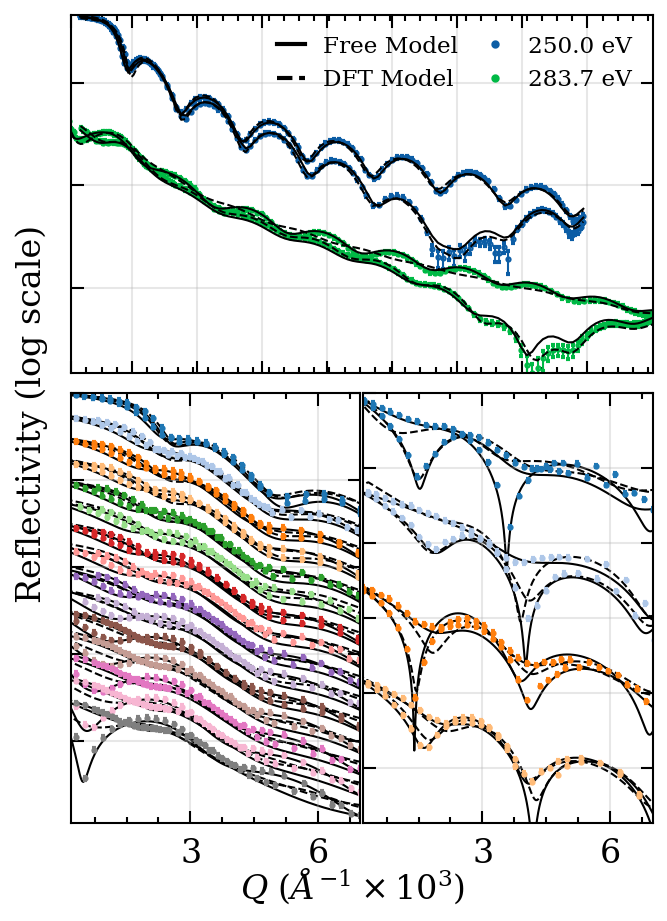

In [11]:
_ = plot_all_results(exp_constrained, dft_constrained, loaded_data)

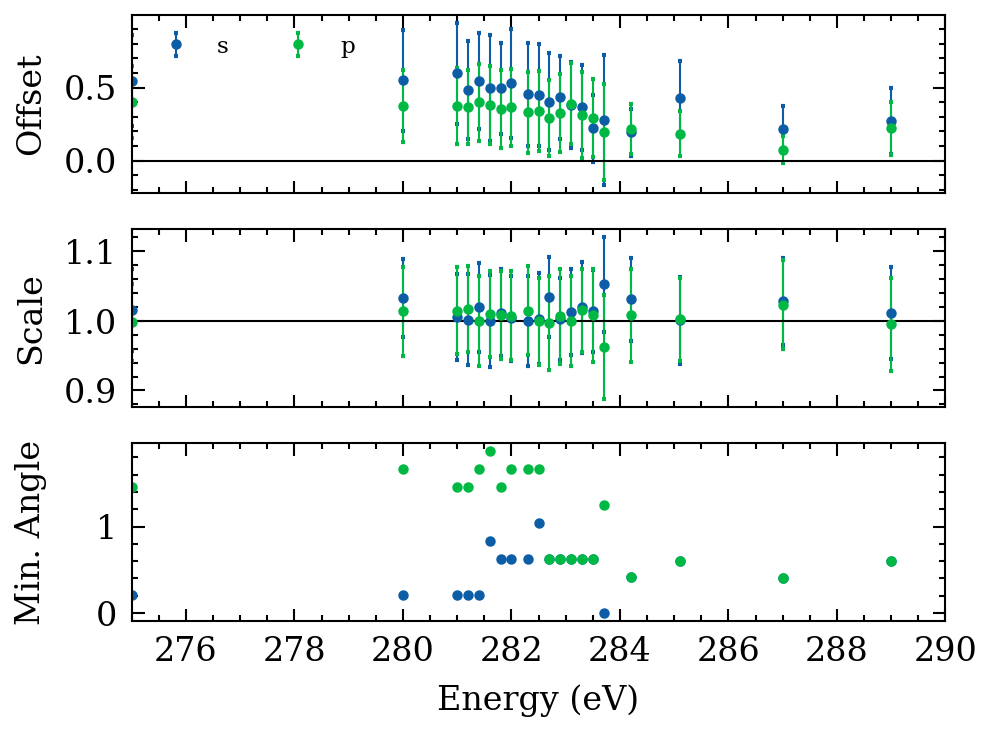

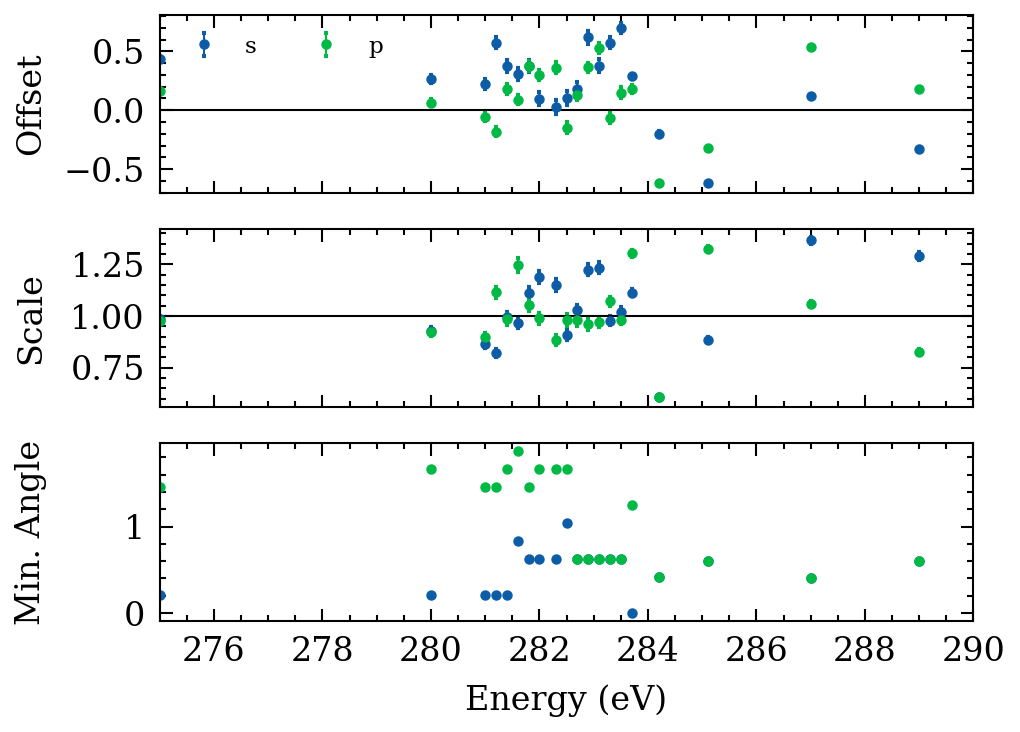

In [12]:
# Calculate wavelength in inverse angstroms from energy in eV
def wavelength_from_energy(energy):
    return 12398.42 / energy

# Calculate theta from q (A^-1)
def theta_from_q(q, energy):
    wavelength = wavelength_from_energy(energy)
    return np.rad2deg(np.arcsin(q * wavelength / (4 * np.pi)))

def theta_offset_bounds(data, energy):
    minq = np.min(data.x)
    maxq = np.max(data.x)
    min_theta = theta_from_q(minq, energy)
    max_theta = theta_from_q(maxq, energy)
    return min_theta, max_theta

# Plot the offset_s and offset_p values for each energy
def experimental_offsets(objectives):
    _df = []
    for o in objectives:
        # calculate the min incident angle
        data_s = o.data.s
        data_p = o.data.p
        minq_s = np.min(data_s.x)
        minq_p = np.min(data_p.x)
        min_theta_s = theta_from_q(minq_s, o.model.energy)
        min_theta_p = theta_from_q(minq_p, o.model.energy)

        df = _df.append({
            "energy": o.model.energy,
            "min_theta_s": min_theta_s,
            "min_theta_p": min_theta_p,
            "offset_s": o.model.theta_offset_s.value,
            "offset_s_err": o.model.theta_offset_s.stderr,
            "offset_p": o.model.theta_offset_p.value,
            "offset_p_err": o.model.theta_offset_p.stderr,
            "scale_s": o.model.scale_s.value,
            "scale_s_err": o.model.scale_s.stderr,
            "scale_p": o.model.scale_p.value,
            "scale_p_err": o.model.scale_p.stderr
            })
    df = pd.DataFrame(_df)
    return df

exp_df_offsets = experimental_offsets(exp_constrained.objectives)
dft_df_offsets = experimental_offsets(dft_constrained.objectives)
# Plot the offset_s and offset_p values for each energy
def plot_offsets(df, ax):
    ax[0].errorbar(
        df["energy"], df["offset_s"], yerr=df["offset_s_err"], label="s",
        marker="o", linestyle="None", markersize=1.5, ecolor="C0",
        capsize=.5, elinewidth=.5)
    ax[0].errorbar(
        df["energy"], df["offset_p"], yerr=df["offset_p_err"], label="p",
        marker="o", linestyle="None", markersize=1.5, ecolor="C1",
        capsize=.5, elinewidth=.5)
    ax[0].legend(loc="upper left", fontsize="x-small", ncol=2)
    ax[0].set_ylabel("Offset")
    ax[1].errorbar(
        df["energy"], df["scale_s"], yerr=df["scale_s_err"], label="s",
        marker="o", linestyle="None", markersize=1.5, ecolor="C0",
        capsize=.5, elinewidth=.5)
    ax[1].errorbar(
        df["energy"], df["scale_p"], yerr=df["scale_p_err"], label="p",
        marker="o", linestyle="None", markersize=1.5, ecolor="C1",
        capsize=.5, elinewidth=.5)
    ax[1].set_ylabel("Scale")
    ax[2].plot(
        df["energy"], df["min_theta_s"], label="s",
        marker="o", linestyle="None", markersize=1.5)
    ax[2].plot(
        df["energy"], df["min_theta_p"], label="p",
        marker="o", linestyle="None", markersize=1.5)
    ax[0].axhline(0, color="k", linestyle="-", lw=0.5)
    ax[1].axhline(1, color="k", linestyle="-", lw=0.5)
    ax[2].set_ylabel("Min. Angle")
    ax[2].set_xlabel("Energy (eV)")
    ax[2].set_xlim(275, 290)
    fig = ax[0].get_figure()
    fig.align_ylabels(ax)
    plt.show()

fig, ax = plt.subplots(nrows=3, sharex=True)
plot_offsets(exp_df_offsets, ax)
plt.show()

fig, ax = plt.subplots(nrows=3, sharex=True)
plot_offsets(dft_df_offsets, ax)
plt.show()


/tmp/ipykernel_778086/3731991179.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(["0","2", "4"])
/tmp/ipykernel_778086/3731991179.py:159: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_yticklabels(["0","2", "4"])


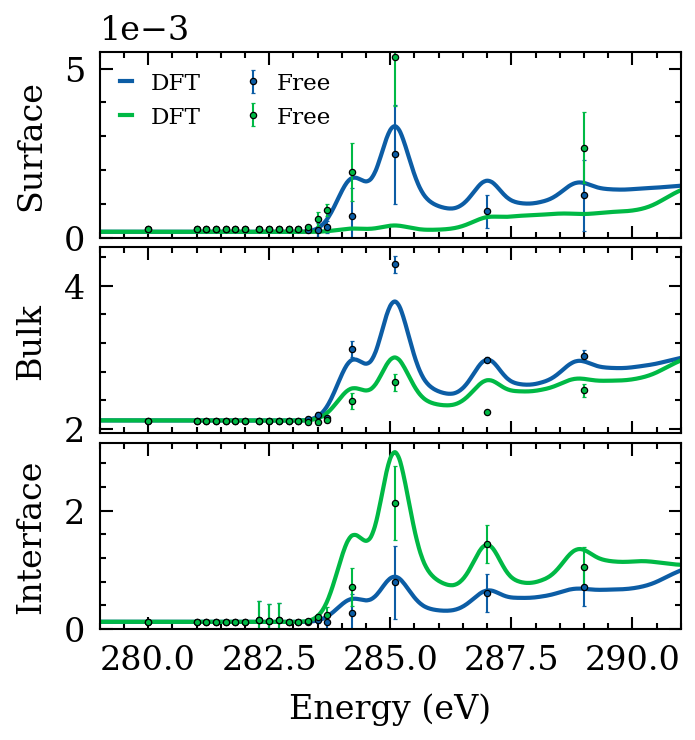

In [13]:
ooc = pd.read_csv("../fitting/optical_constants.csv")
# Zoom from 270 to 300 eV
ooc = ooc[ooc["energy"] > 270]
ooc = ooc[ooc["energy"] < 300]

#  extract orientation from dft_constrained system
rotations = {"contamination": 0.0, "bulk": 0.0, "interface": 0.0}
density = {"contamination": 0.0, "bulk": 0.0, "interface": 0.0}
comparison_energies = np.array([250.0, 283.7])
exp_objectives = {obj.model.energy: obj for obj in exp_constrained.objectives}
dft_objectives = {obj.model.energy: obj for obj in dft_constrained.objectives}
o = dft_objectives[283.7]
rotations["contamination"] = o.model.structure[1].sld.rotation
rotations["bulk"] = o.model.structure[2].sld.rotation
rotations["interface"] = o.model.structure[3].sld.rotation
density["contamination"] = o.model.structure[1].sld.density
density["bulk"] = o.model.structure[2].sld.density
density["interface"] = o.model.structure[3].sld.density

# Extract the imaginary components and their errors from the exp_constrained dataset
def optical_constants(model):
    oc = {}
    names = ["contamination", "bulk", "interface"]
    for i, s in enumerate(model.structure):
        if isinstance(s.sld, fit.UniTensorSLD):
            print(s)
            break
        if i in [0, 4,5]:
            continue
        n_ixx = s.sld.ixx.value
        n_izz = s.sld.izz.value
        n_xx = s.sld.xx.value
        n_zz = s.sld.zz.value
        if n_ixx < 0 or n_izz < 0:
            print(f"Negative n_ixx or n_izz for {s.sld.name} at {s.sld.energy} eV")
            n_ixx = None
            n_izz = None
        #  The data is fit in terms of dichroism, so we need to convert those errors
        dichroerr = s.sld.dichroism.stderr
        bisoerr = s.sld.beta.stderr
        if dichroerr is None or bisoerr is None:
            n_ixx_err = 2 * n_ixx
            n_izz_err = 2 * n_izz
        else:
            n_ixx_err = np.sqrt(dichroerr**2 + bisoerr**2)
            n_izz_err = np.sqrt(dichroerr**2 + bisoerr**2)

        birenreror = s.sld.birefringence.stderr
        disoerr = s.sld.delta.stderr

        if birenreror is not None or disoerr is not None:
            n_xx_err = np.sqrt(birenreror**2 + disoerr**2)
            n_zz_err = np.sqrt(birenreror**2 + disoerr**2)
        else:
            n_xx_err = 2 * n_xx
            n_zz_err = 2 * n_zz

        oc[names[i-1]] = {
            "n_io": n_ixx,
            "n_io_err": n_ixx_err,
            "n_ie": n_izz,
            "n_ie_err": n_izz_err,
            "n_o": n_xx,
            "n_o_err": n_xx_err,
            "n_e": n_zz,
            "n_e_err": n_zz_err,
        }
    return oc

def extract_optical_constants(objectives):
    contamination = []
    bulk = []
    interface = []
    for o in objectives:
        if o.model.energy == 250.0:
            continue
        oc = optical_constants(o.model)
        contamination.append({"energy": o.model.energy, **oc["contamination"]})
        bulk.append({"energy": o.model.energy, **oc["bulk"]})
        interface.append({"energy": o.model.energy, **oc["interface"]})
    contamination = pd.DataFrame(contamination)
    bulk = pd.DataFrame(bulk)
    interface = pd.DataFrame(interface)
    return contamination, bulk, interface

exp_c, exp_b, exp_i = extract_optical_constants(exp_constrained.objectives)

def optical_tensor(ooc, rotation, density):
    """
    Calculate the optical tensor for a given rotation and density.
    """
    c = np.cos(rotation)**2
    s = np.sin(rotation)**2
    n_o = (ooc["n_xx"]* (c+1) + ooc["n_zz"]*s)/2
    n_e = (ooc["n_xx"] * s + ooc["n_zz"] * c)
    n_io = (ooc["n_ixx"]* (c+1) + ooc["n_izz"]*s)/2
    n_ie = (ooc["n_ixx"] * s + ooc["n_izz"] * c)
    return n_o * density, n_e * density, n_io * density, n_ie * density

c_o, c_e, c_io, c_ie = optical_tensor(ooc, rotations["contamination"].value, density["contamination"].value)
b_o, b_e, b_io, b_ie = optical_tensor(ooc, rotations["bulk"].value, density["bulk"].value)
i_o, i_e, i_io, i_ie = optical_tensor(ooc, rotations["interface"].value, density["interface"].value)

#  Make a 3 row plot of these tensor components
fig, axs = plt.subplots(3, 1, figsize=(2.5, 2.5), sharex=True,  gridspec_kw={"hspace": 0.05})

# Surface Imaginary Componsents
axs[0].plot(ooc["energy"], c_io, label="DFT")
axs[0].errorbar(
    exp_c["energy"], exp_c["n_io"], yerr=exp_c["n_io_err"],
    label=r"Free", color="C0", marker="o", linestyle="None",
    markersize=1.5, ecolor="C0", capsize=.5, elinewidth=.5,
    markeredgecolor="k", markerfacecolor="C0", markeredgewidth=0.3
)
# Scientific notation on the y axis
axs[0].ticklabel_format(style="sci", axis="y", scilimits=(0,0))
# Add the experimental data with error bars to this

axs[0].errorbar(
    exp_c["energy"], exp_c["n_ie"], yerr=exp_c["n_ie_err"],
    label=r"Free", color="C1", marker="o", linestyle="None",
    markersize=1.5, ecolor="C1", capsize=.5, elinewidth=.5,
    markeredgecolor="k", markerfacecolor="C1", markeredgewidth=0.3
)
axs[0].plot(ooc["energy"], c_ie, label="DFT")
axs[0].set_ylim(0, 5.5e-3)
axs[0].legend(loc="upper left", handlelength=0.5, fontsize="x-small", ncol=2)
axs[0].set_ylabel("Surface")
axs[0].set_xlabel("Energy (eV)")
axs[0].set_xlim(275, 300)

# Bulk Imaginary Componsents
axs[1].plot(ooc["energy"], b_io, label=r"$\beta_{xx}$")
axs[1].plot(ooc["energy"], b_ie, label=r"$\beta_{zz}$")
axs[1].set_ylabel("Bulk")
axs[1].set_xlabel("Energy (eV)")
axs[1].set_xlim(275, 300)
axs[1].set_yticklabels(["0","2", "4"])
axs[1].errorbar(
    exp_b["energy"], exp_b["n_io"], yerr=exp_b["n_io_err"],
    label="Exp. Bulk", color="C0", marker="o", linestyle="None",
    markersize=1.5, ecolor="C0", capsize=.5, elinewidth=.5,
    markeredgecolor="k", markerfacecolor="C0", markeredgewidth=0.3
)
axs[1].errorbar(
    exp_b["energy"], exp_b["n_ie"], yerr=exp_b["n_ie_err"],
    label="Exp. Bulk", color="C1", marker="o", linestyle="None",
    markersize=1.5, ecolor="C1", capsize=.5, elinewidth=.5,
    markeredgecolor="k", markerfacecolor="C1", markeredgewidth=0.3
)
# axs[1].set_ylim(0, None)

# Interface Imaginary Componsents
axs[2].plot(ooc["energy"], i_io, label=r"$\beta_{xx}$")
axs[2].plot(ooc["energy"], i_ie, label=r"$\beta_{zz}$")
axs[2].set_ylabel("Interface")
axs[2].set_xlabel("Energy (eV)")
axs[2].set_xlim(279, 291)
axs[2].set_yticklabels(["0","2", "4"])
axs[2].errorbar(
    exp_i["energy"], exp_i["n_io"], yerr=exp_i["n_io_err"],
    label="Exp. Interface", color="C0", marker="o", linestyle="None",
    markersize=1.5, ecolor="C0", capsize=.5, elinewidth=.5,
    markeredgecolor="k", markerfacecolor="C0", markeredgewidth=0.3
)
axs[2].errorbar(
    exp_i["energy"], exp_i["n_ie"], yerr=exp_i["n_ie_err"],
    label="Exp. Interface", color="C1", marker="o", linestyle="None",
    markersize=1.5, ecolor="C1", capsize=.5, elinewidth=.5,
    markeredgecolor="k", markerfacecolor="C1", markeredgewidth=0.3
)
axs[2].set_ylim(0, None)
plt.show()

[Text(0, -0.005, '-5'), Text(0, 0.0, '0'), Text(0, 0.005, '5')]

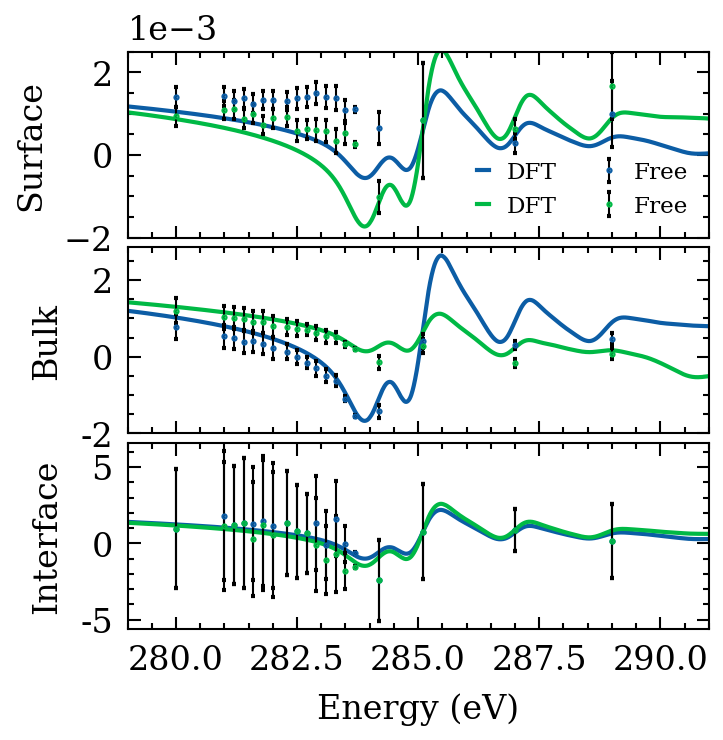

In [28]:
# Plot delta
fig, axs = plt.subplots(3, 1, figsize=(2.5, 2.5), sharex=True,  gridspec_kw={"hspace": 0.05})
axs[0].plot(ooc["energy"], c_o, label="DFT")
axs[0].errorbar(
    exp_c["energy"], exp_c["n_o"], yerr=exp_c["n_o_err"],
    label="Free", color="C0", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[0].plot(ooc["energy"], c_e, label="DFT")
axs[0].errorbar(
    exp_c["energy"], exp_c["n_e"], yerr=exp_c["n_e_err"],
    label="Free", color="C1", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[0].set_ylabel("Surface")
axs[0].set_xlabel("Energy (eV)")
axs[0].set_xlim(275, 300)
axs[0].set_ylim(-2e-3, 2.5e-3)
axs[0].set_yticks([-2e-3,  0, 2e-3])
axs[0].ticklabel_format(style="sci", axis="y", scilimits=(0,0))
axs[0].legend(loc="lower right", handlelength=0.5, fontsize="x-small", ncol=2)


axs[1].plot(ooc["energy"], b_o, label=r"$\delta_{xx}$")
axs[1].plot(ooc["energy"], b_e, label=r"$\delta_{zz}$")
# axs[1].legend(loc="upper left")
axs[1].set_ylabel("Bulk")
axs[1].set_xlabel("Energy (eV)")
axs[1].set_xlim(275, 300)
axs[1].errorbar(
    exp_b["energy"], exp_b["n_o"], yerr=exp_b["n_o_err"],
    label="Exp. Bulk", color="C0", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[1].errorbar(
    exp_b["energy"], exp_b["n_e"], yerr=exp_b["n_e_err"],
    label="Exp. Bulk", color="C1", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[1].set_yticks([-2e-3,  0, 2e-3])
axs[1].set_yticklabels(["-2", "0", "2"])
# axs[1].set_ylim(0, None)

axs[2].plot(ooc["energy"], i_o, label=r"$\delta_{xx}$")
axs[2].plot(ooc["energy"], i_e, label=r"$\delta_{zz}$")
# axs[2].legend(loc="upper left")
axs[2].set_ylabel("Interface")
axs[2].set_xlabel("Energy (eV)")
axs[2].set_xlim(279, 291)
axs[2].errorbar(
    exp_i["energy"], exp_i["n_o"], yerr=exp_i["n_o_err"],
    label="Exp. Interface", color="C0", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[2].errorbar(
    exp_i["energy"], exp_i["n_e"], yerr=exp_i["n_e_err"],
    label="Exp. Interface", color="C1", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[2].set_yticks([-5e-3,  0, 5e-3])
axs[2].set_yticklabels(["-5", "0", "5"])


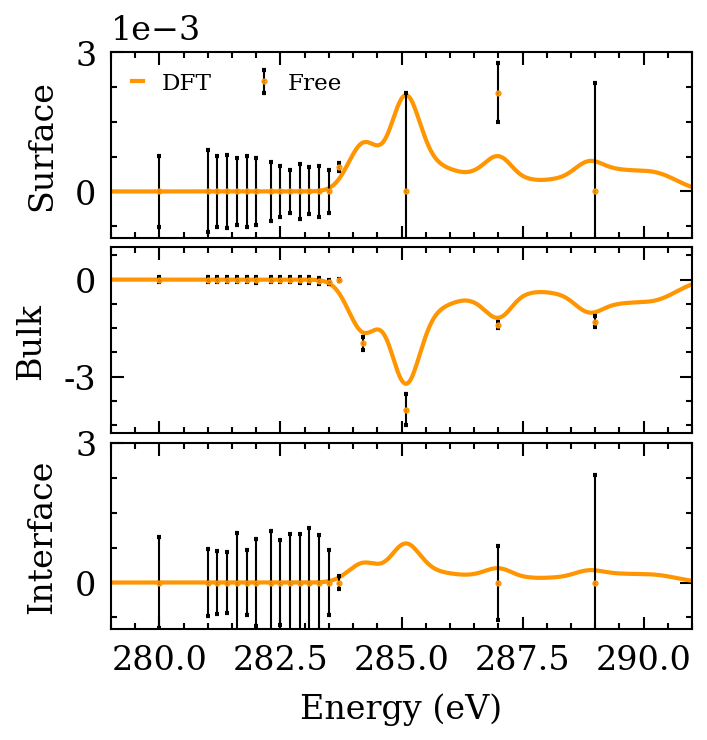

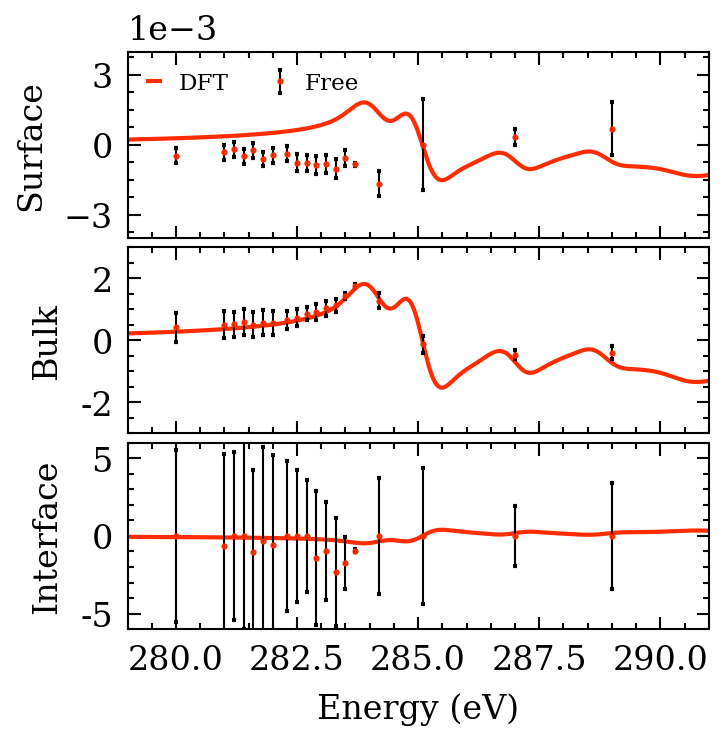

In [29]:
# Interface Dichroism plot (n_ie - n_io)
fig, axs = plt.subplots(3, 1, figsize=(2.5, 2.5), sharex=True,  gridspec_kw={"hspace": 0.05})

# Surface Dichroism
axs[0].plot(ooc["energy"], c_ie - c_io, label="DFT", color="C2")
axs[0].errorbar(
    exp_c["energy"], exp_c["n_ie"] - exp_c["n_io"],
    yerr=np.sqrt(exp_c["n_ie_err"]**2 + exp_c["n_io_err"]**2),
    label="Free", color="C2", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[0].set_ylabel("Surface")
axs[0].set_xlabel("Energy (eV)")
axs[0].set_xlim(275, 300)
axs[0].set_ylim(-1e-3, None)
axs[0].legend(loc="upper left", handlelength=0.5, fontsize="x-small", ncol=2)
axs[0].set_yticks([0, 3e-3])
axs[0].ticklabel_format(style="sci", axis="y", scilimits=(0,0))

# Bulk Dichroism
axs[1].plot(ooc["energy"], b_ie - b_io, label="DFT", color="C2")
axs[1].errorbar(
    exp_b["energy"], exp_b["n_ie"] - exp_b["n_io"],
    yerr=np.sqrt(exp_b["n_ie_err"]**2 + exp_b["n_io_err"]**2),
    label="Bulk", color="C2", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[1].set_ylabel("Bulk")
axs[1].set_xlabel("Energy (eV)")
axs[1].set_xlim(275, 300)
axs[1].set_ylim(None, 1e-3)
axs[1].set_yticks([-3e-3, 0])
axs[1].set_yticklabels([f"{round(y*1e3)}" for y in axs[1].get_yticks()])

# Interface Dichroism
axs[2].plot(ooc["energy"], i_ie - i_io, label="DFT", color="C2")
axs[2].errorbar(
    exp_i["energy"], exp_i["n_ie"] - exp_i["n_io"],
    yerr=np.sqrt(exp_i["n_ie_err"]**2 + exp_i["n_io_err"]**2),
    label="Interface", color="C2", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[2].set_ylabel("Interface")
axs[2].set_xlabel("Energy (eV)")
axs[2].set_xlim(279, 291)
axs[2].set_ylim(-1e-3, None)
axs[2].set_yticks([0, 3e-3])
axs[2].set_yticklabels([f"{round(y*1e3)}" for y in axs[2].get_yticks()])
plt.show()

# Birefringence (n_e - n_o)
fig, axs = plt.subplots(3, 1, figsize=(2.5, 2.5), sharex=True,  gridspec_kw={"hspace": 0.05})

# Surface
axs[0].plot(ooc["energy"], b_e - b_o, label="DFT", color="C3")
axs[0].errorbar(
    exp_c["energy"], exp_c["n_e"] - exp_c["n_o"],
    yerr=np.sqrt(exp_c["n_e_err"]**2 + exp_c["n_o_err"]**2),
    label="Free", color="C3", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[0].set_ylabel("Surface")
axs[0].set_xlabel("Energy (eV)")
axs[0].set_xlim(275, 300)
axs[0].set_ylim(-4e-3, 4e-3)
axs[0].legend(loc="upper left", handlelength=0.5, fontsize="x-small", ncol=2)
axs[0].set_yticks([-3e-3, 0, 3e-3])
axs[0].ticklabel_format(style="sci", axis="y", scilimits=(0,0))

# Bulk
axs[1].plot(ooc["energy"], b_e - b_o, label="DFT", color="C3")
axs[1].errorbar(
    exp_b["energy"], exp_b["n_e"] - exp_b["n_o"],
    yerr=np.sqrt(exp_b["n_e_err"]**2 + exp_b["n_o_err"]**2),
    label="Bulk", color="C3", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[1].set_ylabel("Bulk")
axs[1].set_xlabel("Energy (eV)")
axs[1].set_xlim(275, 300)
axs[1].set_ylim(-3e-3, 3e-3)
axs[1].set_yticks([-2e-3, 0, 2e-3])
axs[1].set_yticklabels([f"{round(y*1e3)}" for y in axs[1].get_yticks()])

# Interface
axs[2].plot(ooc["energy"], i_e - i_o, label="DFT", color="C3")
axs[2].errorbar(
    exp_i["energy"], exp_i["n_e"] - exp_i["n_o"],
    yerr=np.sqrt(exp_i["n_e_err"]**2 + exp_i["n_o_err"]**2),
    label="Interface", color="C3", marker="o", linestyle="None",
    markersize=.5, ecolor="k", capsize=.5, elinewidth=.5
)
axs[2].set_ylabel("Interface")
axs[2].set_xlabel("Energy (eV)")
axs[2].set_xlim(279, 291)
axs[2].set_ylim(-6e-3, 6e-3)
axs[2].set_yticks([-5e-3, 0, 5e-3])
axs[2].set_yticklabels([f"{round(y*1e3)}" for y in axs[2].get_yticks()])
plt.show()


/tmp/ipykernel_1133043/565510789.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(energies))
/tmp/ipykernel_1133043/565510789.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(energies))


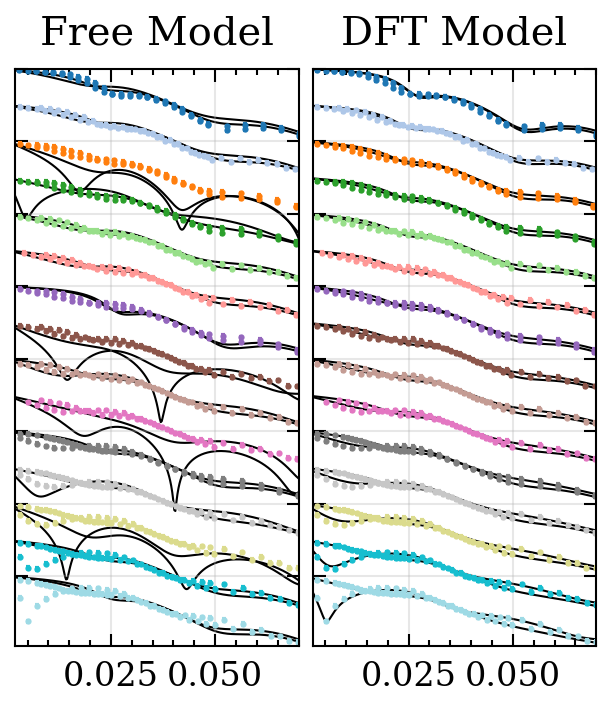

In [30]:
all_energies = sorted([obj.model.energy for obj in exp_constrained.objectives])
non_resonant = [e for e in all_energies if 250.0 < e < 283.7]

non_resonant_data = {str(obj.model.energy): obj.data for obj in exp_constrained.objectives if obj.model.energy in non_resonant}
dft_objs = {e: obj for e, obj in zip(all_energies, dft_constrained.objectives)}
exp_objs = {e: obj for e, obj in zip(all_energies, exp_constrained.objectives)}

def plot_offset_energies(ax, energies, objectives, loaded_data, title, offset_scale=-1.5):
    """
    Helper function to plot multiple energies with vertical offsets.
    """
    import matplotlib.cm as cm

    # Create color map
    cmap = cm.get_cmap('tab20', len(energies))
    xdata = np.linspace(0.0005, 0.25, 1000)
    for idx, E in enumerate(energies):
        if E not in objectives:
            continue

        o = objectives[E]
        data = loaded_data[str(E)]

        # Vertical offset (powers of 10)
        offset = 10 ** (offset_scale * idx)
        color = cmap(idx)

        # Plot data points (smaller markers)
        for pol, marker_style in [("s", "o"), ("p", "s")]:
            pol_data = getattr(data, pol)
            ax.errorbar(
                pol_data.x,
                pol_data.y * offset,
                yerr=pol_data.y_err * offset,
                lw=0,
                color=color,
                capsize=.5,
                # ecolor="k",
                marker="o",
                elinewidth=.5,
                markersize=.5,
                markerfacecolor=color,
                markevery=2,
                errorevery=2,
            )

        # Plot fits
        for pol in ["s", "p"]:
            pol_data = getattr(data, pol)
            o.model.bkg.value = 0.0
            o.model.theta_offset_s.value = 0.0
            o.model.theta_offset_p.value = 0.0
            o.model.scale_s.value = 1.0
            o.model.scale_p.value = 1.0

            # Free fit (exp_constrained) - solid line
            y_exp = rxr(xdata, o.model, pol)
            ax.plot(xdata, y_exp * offset, color="k", lw=.5, ls="-", zorder=-10)

    # Configure axes
    ax.set_yscale("log")
    ax.set_xlim(0.002, 0.07)
    ax.minorticks_on()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(offset * pol_data.y.min(), 1)
    # ax.set_xticks([ 0.03, 0.06])
    # ax.set_xticklabels([r"$3$", r"$6$"])
    ax.set_yticklabels([])
    # No legend in bottom panels - will be consolidated in top panel

fig, axs = plt.subplots(1, 2, figsize=(2.5, 2.5), sharex=True,  gridspec_kw={"wspace": 0.05})
plot_offset_energies(axs[0], non_resonant, exp_objs, non_resonant_data, "EXP")
plot_offset_energies(axs[1], non_resonant, dft_objs, non_resonant_data, "DFT")
axs[0].set_title("Free Model")
axs[1].set_title("DFT Model")
plt.show()

#Change the surface delta to see what happens to the output

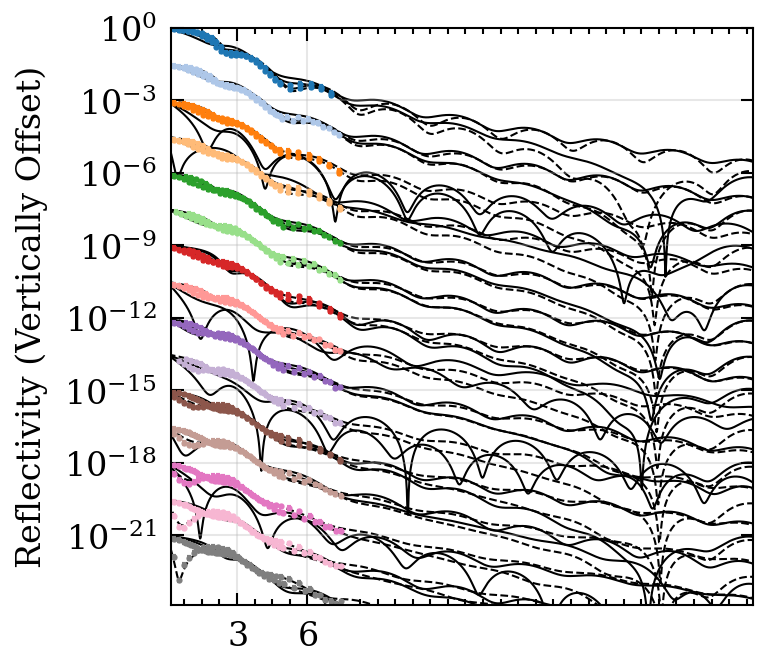

In [31]:
fig, axs = plt.subplots(figsize=(2.5, 2.5), sharex=True,  gridspec_kw={"wspace": 0.05})
plot_vertically_offset_energies(axs, non_resonant, exp_objs, dft_objs, non_resonant_data, "EXP")
axs.set_xlim(0.002, 0.25)
plt.show()

/tmp/ipykernel_1133043/565510789.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(energies))
/tmp/ipykernel_1133043/565510789.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(energies))


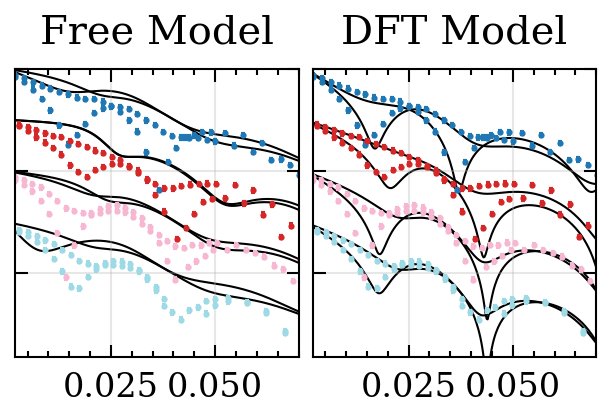

/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/model.py:407: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x * wavelength / (4 * np.pi)) * 180 / np.pi
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:304: RuntimeWarning: invalid value encountered in divide
  knorm = kvec / kdiv[:, :, None]  # (np.linalg.norm(kvec,axis=-1)[:,:,None])
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:313: RuntimeWarning: invalid value encountered in divide
  ((1 + nu) / (1 + nu * kpol[:, 0, None] ** 2))
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:319: RuntimeWarning: invalid value encountered in divide
  ((1 + nu) / (1 + nu * kpol[:, 1, None] ** 2))
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:325: RuntimeWarning: invalid value encountered in divide


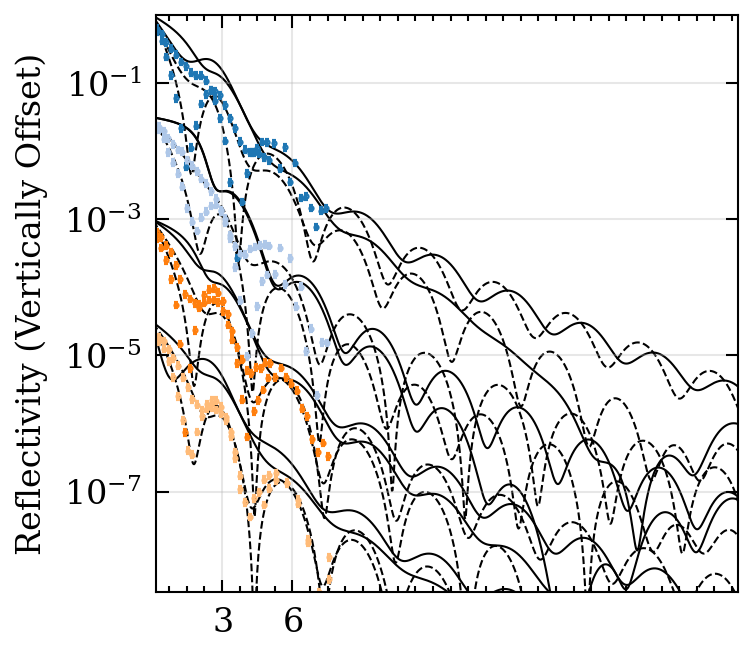

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(2.5, 2.5/2), sharex=True,  gridspec_kw={"wspace": 0.05})
resonant = [e for e in all_energies if 283.7 < e < 300.0]
resonant_data = {str(obj.model.energy): obj.data for obj in exp_constrained.objectives if obj.model.energy in resonant}
resonant_exp_objs = {e: obj for e, obj in zip(all_energies, exp_constrained.objectives)}
resonant_dft_objs = {e: obj for e, obj in zip(all_energies, dft_constrained.objectives)}
plot_offset_energies(axs[0], resonant, resonant_exp_objs, resonant_data, "EXP")
plot_offset_energies(axs[1], resonant, resonant_dft_objs, resonant_data, "DFT")
axs[0].set_title("Free Model")
axs[1].set_title("DFT Model")
plt.show()
fig, axs = plt.subplots(figsize=(2.5, 2.5), sharex=True,  gridspec_kw={"wspace": 0.05})
plot_vertically_offset_energies(axs, resonant, resonant_exp_objs, resonant_dft_objs, resonant_data, "EXP")
axs.set_xlim(0.002, 0.25)
plt.show()

In [33]:
def plot_fit_results(
    objective,
    save_path: Path | str | None = None,
    comparitive_objective=None,
    comparitive_label=None,
):
    """
    Generates a plot of the reflectivity data comparison for s and p polarizations,
    along with the anisotropy and residuals.

    Parameters
    ----------
    objective : refell.Objective
        The objective to plot.
    save_path : str, optional
        The path to save the figure to. If None, the figure is shown.
    comparitive_objective : refell.Objective, optional
        A second objective to plot for comparison.
    """
    data = objective.data
    data.name = ""
    mod = objective.model
    #  Generate a plot of the reflectivity data comparison for the s and p polarizations
    # along with the anisotropy, and a residuals plot
    fig, ((ax_ref, ax_ani), (ax_res, ax_ani_res)) = plt.subplots(
        2, 2, figsize=(10, 3), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )
    #  plot the data
    data.plot(ax=ax_ref, show_anisotropy=False)
    ax_ani.scatter(
        data.anisotropy.x,
        data.anisotropy.y,
        label="Data Anisotropy",
        color="C2",
        marker="o",
        s=10,
    )
    ax_ref.plot(
        data.s.x,
        rxr(data.s.x, mod, "s"),
        label="Fit (s-pol)",
        color="C0",
        linestyle="-",
    )
    #  Plot the models
    ax_ref.plot(
        data.p.x,
        rxr(data.p.x, mod, "p"),
        label="Fit (p-pol)",
        color="C1",
        linestyle="-",
    )
    ax_ani.plot(
        data.anisotropy.x,
        anisotropy(data.anisotropy.x, mod),
        label="Fit Anisotropy",
        color="C2",
        linestyle="-",
    )

    if comparitive_objective:
        mod2 = comparitive_objective.model
        ax_ref.plot(
            data.s.x,
            rxr(data.s.x, mod2, "s"),
            label="Fit2 (s-pol)",
            color="C0",
            linestyle="--",
        )
        ax_ref.plot(
            data.p.x,
            rxr(data.p.x, mod2, "p"),
            label="Fit2 (p-pol)",
            color="C1",
            linestyle="--",
        )
        ax_ani.plot(
            data.anisotropy.x,
            anisotropy(data.anisotropy.x, mod2),
            label="Fit2 Anisotropy",
            color="C2",
            linestyle="--",
        )

    ymin = ax_ref.get_ylim()[0]
    # shade below the background with a hatched area
    ax_ref.fill_between(
        x=data.s.x,
        y1=ymin,
        y2=mod.bkg.value,
        color="none",
        alpha=0.3,
        hatch="//",
        edgecolor="gray",
    )
    ax_ref.set_ylim(ymin, None)
    #  Plot the residuals
    res_s = (data.s.y - rxr(data.s.x, mod, "s")) / data.s.y_err
    res_s_quant = np.quantile(res_s, [0.1, 0.25, 0.5, 0.75, 0.9])
    res_p = (data.p.y - rxr(data.p.x, mod, "p")) / data.p.y_err
    res_p_quant = np.quantile(res_p, [0.1, 0.25, 0.5, 0.75, 0.9])
    res_a = data.anisotropy.y - anisotropy(data.anisotropy.x, mod)
    res_a_quant = np.quantile(res_a, [0.1, 0.25, 0.5, 0.75, 0.9])
    ax_res.plot(
        data.s.x,
        res_s,
        color="C0",
        linestyle="-",
        marker="o",
        markersize=2,
        lw=0.5,
        markerfacecolor="white",
        markeredgecolor="C0",
    )
    ax_res.fill_between(
        x=data.s.x,
        y1=res_s_quant[1],
        y2=res_s_quant[-2],
        color="C0",
        alpha=0.1,
    )
    ax_res.plot(
        data.p.x,
        res_p,
        color="C1",
        linestyle="-",
        marker="o",
        markersize=2,
        lw=0.5,
        markerfacecolor="white",
        markeredgecolor="C1",
    )
    ax_res.fill_between(
        x=data.p.x,
        y1=res_p_quant[1],
        y2=res_p_quant[-2],
        color="C1",
        alpha=0.1,
    )
    ax_res.axhline(
        0,
        color="k",
        linestyle="-",
        lw=plt.rcParams["axes.linewidth"],
    )
    ax_res.set_ylabel("Res.")
    ax_ani_res.plot(
        data.anisotropy.x,
        res_a,
        color="C2",
        linestyle="-",
        marker="o",
        markersize=2,
        lw=0.5,
        markerfacecolor="white",
        markeredgecolor="C2",
    )
    ax_ani_res.fill_between(
        x=data.anisotropy.x,
        y1=res_a_quant[1],
        y2=res_a_quant[-2],
        color="C2",
        alpha=0.1,
    )
    ax_ani_res.axhline(
        0,
        color="k",
        linestyle="-",
        lw=plt.rcParams["axes.linewidth"],
    )

    if comparitive_objective:
        mod2 = comparitive_objective.model
        ax_res.plot(
            data.s.x,
            (data.s.y - rxr(data.s.x, mod2, "s")) / data.s.y_err,
            color="C0",
            linestyle=":",
            marker="s",
            markersize=2,
            lw=0.5,
        )
        ax_res.plot(
            data.p.x,
            (data.p.y - rxr(data.p.x, mod2, "p")) / data.p.y_err,
            color="C1",
            linestyle=":",
            marker="s",
            markersize=2,
            lw=0.5,
        )
        ax_ani_res.plot(
            data.anisotropy.x,
            (data.anisotropy.y - anisotropy(data.anisotropy.x, mod2)),
            color="C2",
            linestyle=":",
            marker="s",
            markersize=2,
            lw=0.5,
        )

    ax_res.set_ylim(res_s_quant[0], res_s_quant[-1])
    ax_ani_res.set_ylim(res_a_quant[0], res_a_quant[-1])

    ax_ani_res.set_ylabel("Res.")
    ax_ref.set_xlim(data.anisotropy.x.min(), data.anisotropy.x.max())
    ax_ref.set_yscale("log")
    ax_ref.set_ylabel("Reflectivity [abs.]")
    ax_res.set_xlabel(r"$Q$ [$\AA^{-1}$]")
    ax_ref.legend(ncols=2, handlelength=0.5)
    ax_res.set_ylim()
    ax_ani.set_ylabel("Anisotropy [abs.]")
    ax_ani_res.set_xlabel(r"$Q$ [$\AA^{-1}$]")
    ax_ani.legend(ncols=2, handlelength=0.5)
    ax_ani.set_xlim(ax_ref.get_xlim())
    ax_ani.set_ylim(-1, 1)
    ax_ani.axhline(
        0,
        color="k",
        linestyle="-",
        lw=plt.rcParams["axes.linewidth"],
    )
    #  annotate the model.scale_s, model.scale_p, model.theta_offset_s, model.theta_offset_p
    scales = (mod.scale_s.value, mod.scale_p.value)
    offsets = (mod.theta_offset_s.value, mod.theta_offset_p.value)
    text = (
        f"Scale (s, p): ({scales[0]:.2f}, {scales[1]:.2f})\n"
        f"Offset (s, p): ({offsets[0]:.2f}, {offsets[1]:.2f})\n"
        f"Background : {mod.bkg.value:.1e}"
    )
    if comparitive_objective:
        mod2 = comparitive_objective.model
        scales2 = (mod2.scale_s.value, mod2.scale_p.value)
        offsets2 = (mod2.theta_offset_s.value, mod2.theta_offset_p.value)
        text = (
            f"Scale (s, p): ({scales[0]:.2f}, {scales[1]:.2f}) | ({scales2[0]:.2f}, {scales2[1]:.2f})\n"
            f"Offset (s, p): ({offsets[0]:.2f}, {offsets[1]:.2f}) | ({offsets2[0]:.2f}, {offsets2[1]:.2f})\n"
            f"Background : {mod.bkg.value:.1e} | {mod2.bkg.value:.1e}"
        )

    ax_ref.text(
        0.05,
        0.3,
        s=text,
        transform=ax_ref.transAxes,
        va="top",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
    )
    fig.align_ylabels()
    fig.suptitle(
        rf"Fit at {mod.energy} eV $\chi^2_{{red}} = {reduced_chi2(objective):.2f}$"
        + (f" | {comparitive_label} in dashed" if comparitive_label else "")
    )

    if save_path:
        fig.savefig(save_path, dpi=300)
        plt.close(fig)
    else:
        plt.show()


def export_fit_results(
    objectives,
    save_folder: Path = Path("figures"),
    comparitive_objectives=None,
    comparitive_label=None,
):
    """
    Export comparison plots for a list of objectives.

    Parameters
    ----------
    objectives : list of refell.Objective
        The objectives to plot.
    folder : str, optional
        The folder to save the figures to. Default is "figures".
    """

    #  add current year_month_day to the folder name
    folder = save_folder / datetime.now().strftime("%Y%m%d")
    if not os.path.exists(folder):
        os.makedirs(folder)
    for obj in objectives:
        comp_obj = (
            next(
                (
                    co
                    for co in comparitive_objectives
                    if co.model.energy == obj.model.energy
                ),
                None,
            )
            if comparitive_objectives
            else None
        )
        energy = obj.model.energy
        save_path = os.path.join(folder, f"fit_comparison_{energy}eV.png")
        plot_fit_results(
            obj,
            save_path=save_path,
            comparitive_objective=comp_obj,
            comparitive_label=comparitive_label,
        )


export_fit_results(
    dft_constrained.objectives, save_folder=Path("figures/dft_constrained")
)
export_fit_results(
    exp_constrained.objectives, save_folder=Path("figures/exp_constrained")
)
export_fit_results(
    dft_constrained.objectives,
    save_folder=Path("figures/comparative"),
    comparitive_objectives=exp_constrained.objectives,
    comparitive_label="Free Model Fit",
)

/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/io.py:190: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [34]:
from matplotlib.lines import Line2D


def export_two_energy_comparison(
    exp_constrained, dft_constrained, loaded_data, output_dir: Path | None = None
):
    """
    Export a comparison plot between experimental and DFT-constrained fits
    at two selected energies.

    Parameters
    ----------
    exp_constrained : refell.FittingResults
        Fitting results with experimental constraints.
    dft_constrained : refell.FittingResults
        Fitting results with DFT constraints.
    loaded_data : dict
        Dictionary containing XrayReflectDataset objects with energy keys.
    """

    # Define the two energies for comparison
    comparison_energies = np.array([250.0, 283.7])

    # Extract the relevant objectives and data for the selected energies
    exp_objectives = {obj.model.energy: obj for obj in exp_constrained.objectives}
    dft_objectives = {obj.model.energy: obj for obj in dft_constrained.objectives}

    cols = ["C0", "C1"]

    fig, (ax, ax_depth1, ax_depth2) = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(8.5, 2),
        constrained_layout=True,
        gridspec_kw={"width_ratios": [3, 1, 1]},
    )

    for i, (E, col) in enumerate(zip(comparison_energies, cols)):
        # ----- Get objects for the current energy -----
        o_exp = exp_objectives[E]
        o_dft = dft_objectives[E]
        data = loaded_data[str(E)]
        scale = 50 ** (-2 * i)  # Vertical offset for clarity
        bkg = data.p.y.min()  # Estimate background from data

        # ----- Helper to prevent log(0) errors -----
        def _clip_low(arr):
            return np.clip(arr, 1e-12, None)

        # ----- Plot Data points with ±2σ error bands -----
        for pol, marker_style in [("s", "o"), ("p", "s")]:
            pol_data = getattr(data, pol)
            ax.fill_between(
                pol_data.x,
                _clip_low((pol_data.y - 2 * pol_data.y_err) * scale),
                (pol_data.y + 2 * pol_data.y_err) * scale,
                color=col,
                alpha=0.15,
            )
            ax.plot(
                pol_data.x,
                pol_data.y * scale,
                color=col,
                lw=2.2,
                marker=marker_style,
                markevery=10,
                markerfacecolor="none",
                markeredgecolor=col,
                markeredgewidth=1.0,
                label="_nolegend_",
            )

        for pol in ["s", "p"]:
            pol_data = getattr(data, pol)
            # Experimental model fit (solid line)
            y_exp = rxr(pol_data.x, o_exp.model, pol)
            ax.plot(pol_data.x, y_exp * scale, color="k", lw=1.5, zorder=10)

            # DFT model fit (dashed line)
            y_dft = rxr(pol_data.x, o_dft.model, pol)
            ax.plot(pol_data.x, y_dft * scale, color="k", lw=1.2, ls="--", zorder=10)

            # Optional: Shade the difference between the two models
            ax.fill_between(
                pol_data.x,
                np.minimum(y_exp, y_dft) * scale,
                np.maximum(y_exp, y_dft) * scale,
                color=col,
                alpha=0.12,
                zorder=5,
            )
    model1 = o_exp.model
    model2 = o_dft.model
    # Plot the depth profiles
    model1.structure.plot(ax=ax_depth1)
    model2.structure.plot(ax=ax_depth2)

    ax_depth1.set_xlabel("Depth (Å)")
    ax_depth1.set_ylabel("Optical Constants (a.u.)")
    ax_depth2.set_xlabel("Depth (Å)")
    ax_depth2.set_ylabel("Optical Constants (a.u.)")
    #  Ensure the legends have 2 columns
    ax_depth1.get_legend()._ncols = 2
    ax_depth2.get_legend()._ncols = 2

    ax.set_xlim(0, 0.27)
    ax.set_yscale("log")
    ax.set_xlabel(r"$Q\ (\AA^{-1})$")
    ax.set_ylabel(r"Reflectivity (a.u.)")
    ax.minorticks_on()

    style_legend_handles = [
        Line2D(
            [],
            [],
            marker="o",
            color="k",
            mfc="none",
            ms=6,
            ls="None",
            label=r"$s$-pol data",
        ),
        Line2D(
            [],
            [],
            marker="s",
            color="k",
            mfc="none",
            ms=6,
            ls="None",
            label=r"$p$-pol data",
        ),
        Line2D([], [], color="k", lw=1.5, ls="-", label=r"Model fit"),
        Line2D([], [], color="k", lw=1.2, ls="--", label=r"DFT fit"),
    ]
    leg1 = ax.legend(
        handles=style_legend_handles,
        loc="upper right",
        fontsize="small",
        title_fontsize="small",
        ncols=2,
        handlelength=0.5,
    )
    ax.add_artist(leg1)

    energy_legend_handles = [Line2D([], [], color=c, lw=2.5) for c in cols]
    energy_labels = [f"{E:.1f} eV" for E in comparison_energies]
    ax.legend(
        handles=energy_legend_handles,
        labels=energy_labels,
        title="Photon energy",
        loc="lower left",
        fontsize="small",
        title_fontsize="small",
        ncols=2,
        handlelength=0.5,
    )
    if output_dir:
        output_dir.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            output_dir
            / f"{datetime.now().strftime('%Y%m%d')}_{comparison_energies[0]}_{comparison_energies[1]}.png",
            dpi=300,
        )
        plt.close(fig)
    else:
        plt.show()


export_two_energy_comparison(
    exp_constrained, dft_constrained, loaded_data, output_dir=Path("figures")
)

In [35]:
import matplotlib.ticker as ticker
from helper import aic, bic

# ------------------------------------------------------------
#  Helper: draw the diagonal break symbols
# ------------------------------------------------------------
def _add_break(ax_left, ax_right, size=5):
    """Draw diagonal break symbols on a pair of axes."""
    d = 2
    kw = dict(
        marker=[(-1, -d), (1, d)],
        markersize=size,
        linestyle="none",
        color="k",
        mec="k",
        mew=1,
        clip_on=False,
    )
    ax_left.plot([1, 1], [0, 1], transform=ax_left.transAxes, **kw)
    ax_right.plot([0, 0], [0, 1], transform=ax_right.transAxes, **kw)

# ------------------------------------------------------------
#  Main plotting routine
# ------------------------------------------------------------
def plot_stats(df_stats: pl.DataFrame, save_path: Path | str | None = None):
    """
    Plot fitting statistics in a 5-row x 2-col layout.
    Left column: 248.5 - 276.5 eV,   Right column: 279.5 - 290 eV.
    Each row shows a single metric (no twin axes).
    Always show total/global reduced chi squared in the first row annotation,
    regardless of whether the local metrics are available.
    """
    # --------------------------------------------------------
    # 1. Split global vs. local rows and extract NumPy arrays
    # --------------------------------------------------------
    global_stats = df_stats.filter(pl.col("Energy (eV)") == 0)
    local = df_stats.filter(pl.col("Energy (eV)") != 0)

    E = local["Energy (eV)"].to_numpy()
    chi2 = local["Reduced Chi^2"].to_numpy()
    bic = local["BIC"].to_numpy()
    aic = local["AIC"].to_numpy()
    npar = local["Number of Parameters"].to_numpy()
    ndata = local["Number of Data Points"].to_numpy()

    # --------------------------------------------------------
    # 2. Define the metrics to plot
    # --------------------------------------------------------
    metrics = [
        ("Reduced chi2", chi2, "C0", r"$\chi^2_{\rm red}$"),
        ("BIC", bic, "C1", "BIC"),
        ("AIC", aic, "C2", "AIC"),
        ("# Params", npar, "C3", "# Params"),
        ("# Data", ndata, "C4", "# Data"),
    ]

    # --------------------------------------------------------
    # 3. Figure / axes layout (5 rows, 2 columns, thin left column)
    # --------------------------------------------------------
    fig, ax = plt.subplots(
        nrows=len(metrics),
        ncols=2,
        figsize=(3, 5),
        gridspec_kw=dict(width_ratios=[1, 9], wspace=0.05, hspace=0.1),
        sharex="col",
    )
    fig.subplots_adjust(bottom=0.08)  # space for the shared x‑label

    # --------------------------------------------------------
    # 4. Energy split masks (left vs. right panel)
    # --------------------------------------------------------
    split_val = 277.0
    left_mask = E <= split_val
    right_mask = E > split_val

    # --------------------------------------------------------
    # 5. Plot each metric
    # --------------------------------------------------------
    for i, (title, y, col, ylabel) in enumerate(metrics):
        # left panel
        ax[i, 0].plot(
            E[left_mask],
            y[left_mask],
            "o",
            markersize=2,
            markerfacecolor="white",
            color=col,
            lw=0.5,
        )
        # right panel
        ax[i, 1].plot(
            E[right_mask],
            y[right_mask],
            "o",
            markersize=2,
            markerfacecolor="white",
            color=col,
            lw=0.5,
        )

        # y‑label on the left side only
        ax[i, 0].set_ylabel(ylabel, color=col)
        # ax[i, 0].tick_params(axis="y", colors=col)

        # --- Annotate global reduced chi2 in first row
        if i == 0 and not global_stats.is_empty():
            # Use the total/global reduced chi2 for annotation
            gval = global_stats["Reduced Chi^2"][0]
            txt = (
                f"Global reduced $\chi^2_{{\\rm red}}$ = {gval:.2f}"
                if isinstance(gval, float)
                else f"Global reduced chi2 = {gval}"
            )
            ax[i, 1].annotate(
                txt,
                xy=(0.05, 0.5),
                xycoords="axes fraction",
                ha="left",
                fontsize=8,
                bbox=dict(
                    boxstyle="round", alpha=0.1, edgecolor="k", facecolor="white"
                ),
            )
        # For all other metrics, optionally add global annotation if present
        elif i != 0 and not global_stats.is_empty() and title in global_stats.columns:
            gval = global_stats[title][0]
            txt = (
                f"Global {title} = {gval:.2f}"
                if isinstance(gval, float)
                else f"Global {title} = {gval}"
            )
            ax[i, 1].annotate(
                txt,
                xy=(0.05, 0.5),
                xycoords="axes fraction",
                ha="left",
                fontsize=8,
                bbox=dict(
                    boxstyle="round", alpha=0.1, edgecolor="k", facecolor="white"
                ),
            )

        # break symbols
        _add_break(ax[i, 0], ax[i, 1])

        # ----------------------------------------------------
        # hide inner spines and their ticks (the “break” region)
        # ----------------------------------------------------
        ax[i, 0].spines["right"].set_visible(False)
        ax[i, 0].yaxis.set_ticks_position("left")
        ax[i, 1].spines["left"].set_visible(False)
        ax[i, 1].yaxis.set_ticks_position("right")
        # # optional: hide top spines for a cleaner look
        # ax[i, 0].spines["top"].set_visible(False)
        # ax[i, 1].spines["top"].set_visible(False)

    # --------------------------------------------------------
    # 6. Axis limits & tick formatting
    # --------------------------------------------------------
    left_xlim = (248.5, 276.5)
    right_xlim = (279.5, 290.0)

    for a in ax[:, 0].flatten():
        a.set_xlim(*left_xlim)
    for a in ax[:, 1].flatten():
        a.set_xlim(*right_xlim)
        a.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # show x‑ticks only on the bottom row
    ax[-1, 0].tick_params(bottom=True, labelbottom=True)
    ax[-1, 1].tick_params(bottom=True, labelbottom=True)

    # --------------------------------------------------------
    # 7. Figure‑wide labels & layout
    # --------------------------------------------------------
    fig.supxlabel("Energy (eV)", y=0.02)
    fig.align_ylabels()
    fig.tight_layout(rect=[0, 0, 1, 0.96])  # keep space for supxlabel

    # --------------------------------------------------------
    # 8. Save or display
    # --------------------------------------------------------
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

def export_stats(objectives, save_path: Path):
    """
    Export fitting statistics for a list of objectives to a CSV file.

    Parameters
    ----------
    objectives : list of refell.Objective
        The objectives to analyze.
    save_path : str, optional
        The path to save the CSV file to. Default is "fitting_stats.csv".
    """
    #  append the date_time to the save_path name
    save_path = save_path.with_name(
        f"{save_path.stem}_{datetime.now().strftime('%Y%m%d')}.csv"
    )
    #  Make the parent directory if it doesn't exist
    save_path.parent.mkdir(parents=True, exist_ok=True)
    stats = []
    for obj in objectives:
        energy = obj.model.energy
        chi2_red = reduced_chi2(obj)
        n_params = len(obj.varying_parameters())
        n_data = len(obj.data.s.x) + len(obj.data.p.x)
        stats.append(
            {
                "Energy (eV)": energy,
                "Reduced Chi^2": chi2_red,
                "Number of Parameters": n_params,
                "Number of Data Points": n_data,
                "AIC": aic(obj),
                "BIC": bic(obj),
            }
        )
    #  Use a global objective to save the total stats
    _glob = fit.GlobalObjective(objectives)
    global_stats = {
        "Energy (eV)": 0,
        "Reduced Chi^2": reduced_chi2(_glob),
        "Number of Parameters": len(_glob.varying_parameters()),
        "Number of Data Points": sum(
            len(obj.data.s.x) + len(obj.data.p.x) for obj in objectives
        ),
        "AIC": aic(_glob),
        "BIC": bic(_glob),
    }
    stats.append(global_stats)
    df_stats = pl.DataFrame(stats)
    #  Sort by Energy
    df_stats = df_stats.sort("Energy (eV)")
    df_stats.write_csv(save_path)
    #  Also plot the stats
    plot_stats(df_stats, save_path=save_path.with_suffix(".png"))
    return df_stats

def export_model_comparison_stats(dft_objectives, exp_objectives, save_path: Path):
    """
    Given two sets of objectives, export their stats and compare them via
    Akaike weights and Bayes factors (BIC).
    Handles extreme differences robustly to avoid overflow and division by zero.
    """
    import math
    import warnings

    def safe_exp(x, max_exp=700):
        """Compute exp(x) safely, with overflow protection."""
        if x > max_exp:
            return math.exp(max_exp)
        elif x < -max_exp:
            return math.exp(-max_exp)
        else:
            return math.exp(x)

    # Save individual stats as CSVs and get their stats DataFrames
    dft_stats = export_stats(dft_objectives, save_path=save_path.with_name(f"{save_path.stem}_dft.csv"))
    exp_stats = export_stats(exp_objectives, save_path=save_path.with_name(f"{save_path.stem}_exp.csv"))

    # Pick the global stats row (Energy = 0)
    dft_global = dft_stats.filter(pl.col("Energy (eV)") == 0).row(0)
    exp_global = exp_stats.filter(pl.col("Energy (eV)") == 0).row(0)

    AICs = [dft_global[dft_stats.columns.index("AIC")], exp_global[exp_stats.columns.index("AIC")]]
    BICs = [dft_global[dft_stats.columns.index("BIC")], exp_global[exp_stats.columns.index("BIC")]]

    # To maintain order: index 0 is DFT, 1 is EXP
    dAIC = AICs[1] - AICs[0]  # EXP - DFT
    dBIC = BICs[1] - BICs[0]  # EXP - DFT

    # Compute Akaike weights for DFT and EXP models robustly using log-sum-exp trick
    # exp(-0.5*(AIC_i - min_AIC)) for each model, but avoid overflow for big AIC diffs
    min_AIC = min(AICs)
    dAICs = [AIC - min_AIC for AIC in AICs]
    # To avoid infs: logw = -0.5*dAIC. Subtract max to stabilize
    log_weights = [-0.5 * dAIC for dAIC in dAICs]
    maxlog = max(log_weights)
    exp_log_weights = [math.exp(lw - maxlog) for lw in log_weights]
    akaike_weights_sum = sum(exp_log_weights)
    akaike_weights = [w / akaike_weights_sum for w in exp_log_weights]
    weight_dft = akaike_weights[0]
    weight_exp = akaike_weights[1]

    # Bayes factor from BICs: BF = exp((BIC_EXP - BIC_DFT)/2)
    # Robust to overflow/underflow:
    try:
        dBIC_over_2 = (BICs[1] - BICs[0]) / 2.0  # EXP - DFT
        # Limit the magnitude to avoid overflow
        if dBIC_over_2 > 700:
            bayes_factor = float('inf')
        elif dBIC_over_2 < -700:
            bayes_factor = 0.0
        else:
            bayes_factor = math.exp(dBIC_over_2)
    except OverflowError:
        warnings.warn("Bayes factor calculation overflowed")
        bayes_factor = float('inf') if dBIC_over_2 > 0 else 0.0

    # Also, robustly report 1/bayes_factor
    if bayes_factor in [0.0, float('inf')]:
        # set reciprocals accordingly
        inv_bayes_factor = 0.0 if bayes_factor == float('inf') else float('inf')
    else:
        inv_bayes_factor = 1.0 / bayes_factor

    # Save a comparison summary
    comparison_stats = [
        {
            "Model": "DFT",
            "AIC": AICs[0],
            "BIC": BICs[0],
            "Akaike weight": weight_dft,
            "Bayes factor (DFT/EXP)": bayes_factor,
        },
        {
            "Model": "Experiment",
            "AIC": AICs[1],
            "BIC": BICs[1],
            "Akaike weight": weight_exp,
            "Bayes factor (DFT/EXP)": inv_bayes_factor,
        },
    ]
    # Save as CSV and print to file
    cmp_df = pl.DataFrame(comparison_stats)
    cmp_path = save_path.with_name(f"{save_path.stem}_model_comparison.csv")
    cmp_df.write_csv(cmp_path)
    # Optionally print
    print("--- Model comparison statistics ---")
    print(cmp_df)
    print(f"> Akaike weight (DFT vs EXP): {weight_dft:.3f} vs {weight_exp:.3f}")
    if bayes_factor == float('inf'):
        print("> Bayes factor (DFT/EXP): inf (extremely strong evidence for DFT)")
    elif bayes_factor == 0.0:
        print("> Bayes factor (DFT/EXP): 0 (extremely strong evidence for Experiment)")
    else:
        print(f"> Bayes factor (DFT/EXP): {bayes_factor:.2f}")
    print(f"Results saved to {cmp_path.resolve()}")

export_model_comparison_stats(
    dft_constrained.objectives,
    exp_constrained.objectives,
    save_path=Path("figures/fitting_stats.csv"),
)

/tmp/ipykernel_1133043/2647850976.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])  # keep space for supxlabel


--- Model comparison statistics ---
shape: (2, 5)
┌────────────┬──────────────┬──────────────┬───────────────┬────────────────────────┐
│ Model      ┆ AIC          ┆ BIC          ┆ Akaike weight ┆ Bayes factor (DFT/EXP) │
│ ---        ┆ ---          ┆ ---          ┆ ---           ┆ ---                    │
│ str        ┆ f64          ┆ f64          ┆ f64           ┆ f64                    │
╞════════════╪══════════════╪══════════════╪═══════════════╪════════════════════════╡
│ DFT        ┆ 14210.605059 ┆ 14809.045968 ┆ 0.0           ┆ 0.0                    │
│ Experiment ┆ 2820.407353  ┆ 4757.93386   ┆ 1.0           ┆ inf                    │
└────────────┴──────────────┴──────────────┴───────────────┴────────────────────────┘
> Akaike weight (DFT vs EXP): 0.000 vs 1.000
> Bayes factor (DFT/EXP): 0 (extremely strong evidence for Experiment)
Results saved to /home/hduva/projects/xrr_notebooks/manuscript/figures/fitting_stats_model_comparison.csv


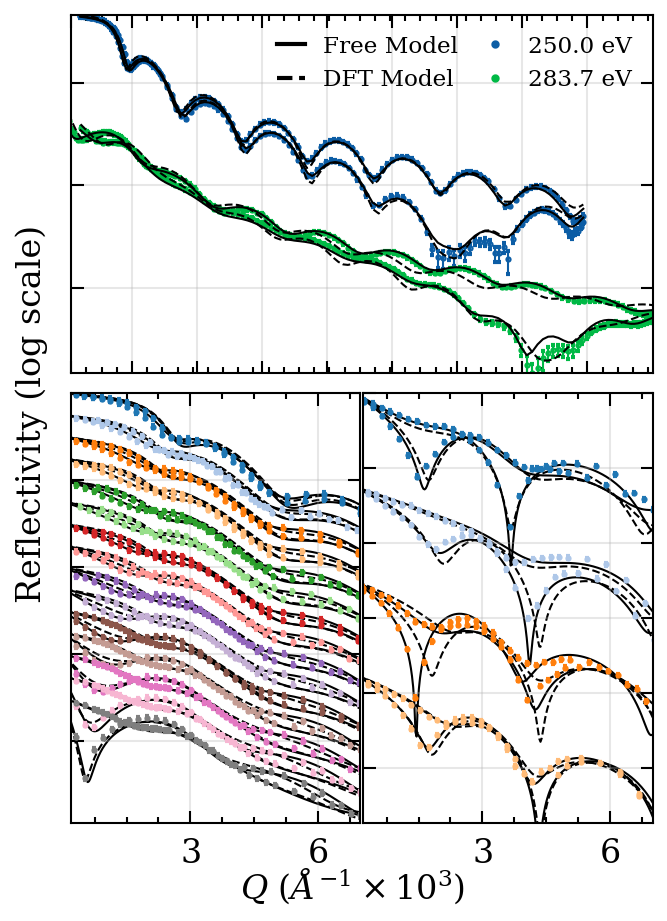

In [17]:
# Generate the comprehensive figure
plot_all_results(
    exp_constrained,
    dft_constrained,
    loaded_data,
    save_path=Path("figures/comprehensive_fit_comparison.png")
)
